In [15]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, ReLU, Input,Softmax


from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Colab Notebooks/UOWC")
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/Colab Notebooks/UOWC'

In [16]:
# Function to create the model
def create_model(input_length):
    model = Sequential()
    model.add(Input(shape=(input_length,)))
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dense(96))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dense(96))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dense(1, activation='sigmoid'))  # For binary classification
    model.compile( optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    return model

In [17]:
class DataGenerator(Sequence):
    def __init__(self, data, labels, batch_size=512, shuffle=True):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.data))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X = self.data[batch_indices]
        y = self.labels[batch_indices]
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
            # Custom callback to print accuracy with more decimal places
class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}: Accuracy = {logs['accuracy']:.15f}, Validation Accuracy = {logs['val_accuracy']:.15f}")

In [18]:
# Load the dataset
file_path = 'supervised_dataset.csv'
data = pd.read_csv(file_path)

# Shuffle the dataset
shuffled_data = shuffle(data)

# Split the dataset into features (X) and labels (y)
X = shuffled_data[['Feature']].values
Y = shuffled_data['Label'].values

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create data generators
batch_size = 32
training_generator = DataGenerator(X_train, Y_train, batch_size=batch_size)
validation_generator = DataGenerator(X_test, Y_test, batch_size=batch_size)

# Adjust input_length to match the number of features
input_length = X_train.shape[1]

# Create the model
CNN0 = create_model(input_length)
# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
# Train the model using the data generator
# history = CNN0.fit(training_generator, validation_data=validation_generator, epochs=30)
history = CNN0.fit(training_generator, validation_data=validation_generator, epochs=30, callbacks=[reduce_lr, CustomCallback()])
# Evaluate the model
loss, accuracy = CNN0.evaluate(validation_generator)

print(f'Final Training Accuracy: {history.history["accuracy"][-1]}')
print(f'Test Accuracy: {accuracy}')

# Predict the labels for the test set
predictions = CNN0.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)

# Print original data, original labels, and predicted labels
print("\nOriginal Data, Original Labels, Predicted Labels:")
for i in range(len(X_test)):
    print(f"Data: {X_test[i]}, Original Label: {Y_test[i]}, Predicted Label: {predicted_labels[i][0]}")


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 256)               512       
                                                                 
 batch_normalization_18 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 re_lu_18 (ReLU)             (None, 256)               0         
                                                                 
 dense_25 (Dense)            (None, 96)                24672     
                                                                 
 batch_normalization_19 (Ba  (None, 96)                384       
 tchNormalization)                                               
                                                                 
 re_lu_19 (ReLU)             (None, 96)               

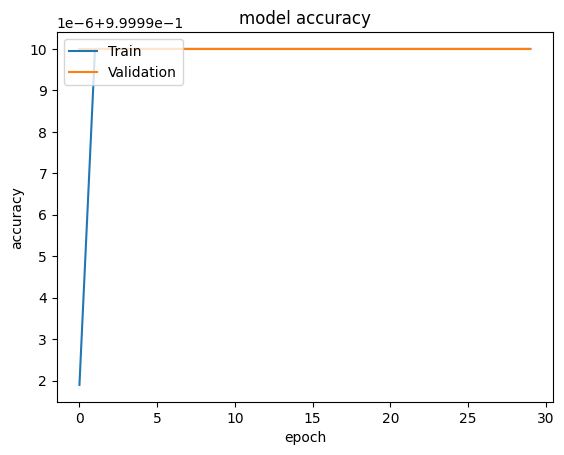

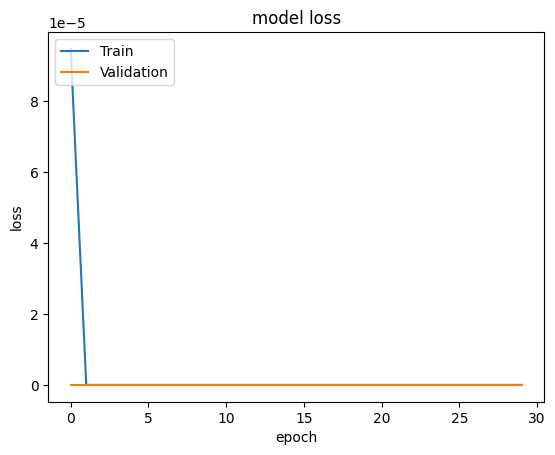

In [19]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()